Sources: 

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

https://www.tensorflow.org/tutorials/load_data/tfrecord

https://www.tensorflow.org/tutorials/generative/cyclegan

https://www.kaggle.com/code/zahid0/gan-tensorflow

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install git+https://github.com/tensorflow/examples.git
# from tensorflow_examples.models.pix2pix import pix2pix
# import time
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate
from keras.layers import ZeroPadding2D

In [2]:
#importing the photos as files according to tutorial kaggle recommends to use
#gets each file from monet and photo tfrec folder
monet_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/photo_tfrec/*.tfrec')
print(len(monet_files))
print(len(photo_files))

5
20


In [3]:
#setting the formats, for the parser to get into tf dataset
formats = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}
def tfrecord_img(instance):
    #parsing the single instance with proper format
    img = tf.io.parse_single_example(instance, formats)
    img = img['image']
    #decoding the image to show it is a rgb color scheme
    img_decode = tf.image.decode_jpeg(img, channels = 3)
    #casting the image pixels to float 32 and normalizing to [-1, 1]
    img_cast = (tf.cast(img_decode, tf.float32) / 127.5) - 1
    #reshaping to (256, 256, 3) for 256 256 size and 3 for channel
    img_reshape = tf.reshape(img_cast, [*[256, 256], 3])
    #randomly flipping images across the y-axis
    img_final = tf.image.random_flip_left_right(img_reshape)
    return img_final
    
    
monet_dataset = tf.data.TFRecordDataset(monet_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)
photo_dataset = tf.data.TFRecordDataset(photo_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)
# monet_dataset = monet_dataset.prefetch(buffer_size=16)
# photo_dataset = photo_dataset.prefetch(buffer_size=16)


Metal device set to: Apple M2


2023-03-03 11:55:45.013943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 11:55:45.013960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-03-03 11:55:45.083425: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


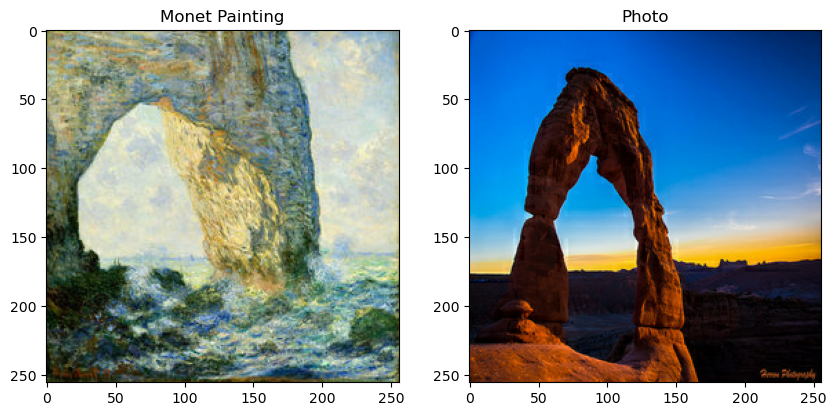

In [4]:
#printing the pictures of monet and photos

monet_single = next((iter(monet_dataset)))
photo_single = next(iter(photo_dataset))

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 10))
ax.imshow(monet_single[0] * 0.5 + .5)
ax.title.set_text('Monet Painting')
ax1.imshow(photo_single[0] * 0.5 + .5)
ax1.title.set_text('Photo')

In [5]:
# def generate_images(model, test_input):
#     prediction = model(test_input)

#     plt.figure(figsize=(12, 12))

#     display_list = [test_input[0], prediction[0]]
#     title = ['Input Image', 'Predicted Image']

#     for i in range(2):
#     plt.subplot(1, 2, i+1)
#     plt.title(title[i])
#     # getting the pixel values between [0, 1] to plot it.
#     plt.imshow(display_list[i] * 0.5 + 0.5)
#     plt.axis('off')
#     plt.show()

In [6]:
#https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

#encoder(downsampler)
def encoder(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2D(filters, size,
                    strides=2, padding='same',
                    kernel_initializer=initializer, use_bias = False))
    if apply_batchnorm:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model
    
    
#decoder (upsampler)
def decoder(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())
    if apply_dropout:
        model.add(Dropout(0.5))
    model.add(ReLU())
    return model


In [7]:
#generator
def Generator():
    inputs = Input(shape=[256, 256, 3])
    down_stack = [
        encoder(64, 4, apply_batchnorm=False),
        encoder(128, 4),
        encoder(256, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4)
    ]
    up_stack = [
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4),
        decoder(256, 4),
        decoder(128, 4),
        decoder(64, 4)
    ]
    initializer = tf.random_normal_initializer(0, 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer=initializer,
                          activation = 'tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

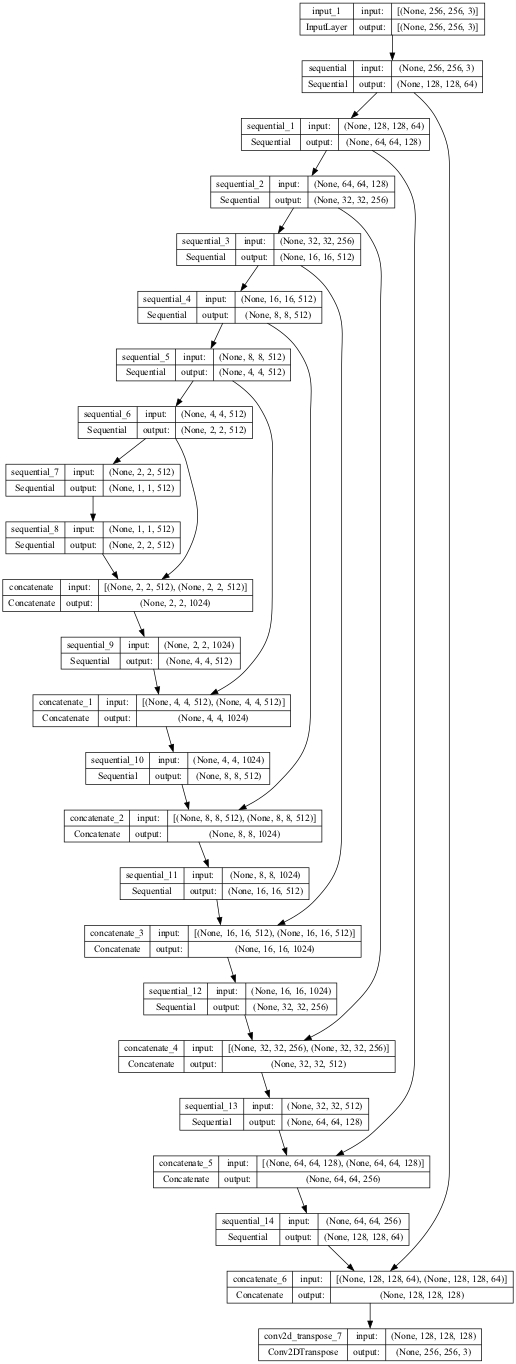

In [8]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=50)

In [9]:
#setting loss function to be binary crossentropy
binary_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#building loss function for our discriminator
def discriminator_loss(real_image, generated_image):
    loss_for_real = binary_loss(tf.ones_like(real_image), real_image)
    loss_for_generated = binary_loss(tf.zeros_like(generated_image), generated_image)
    total_loss_for_discriminator = loss_for_generated + loss_for_real
    return total_loss_for_discriminator * 0.5
#building loss function for generator
def generator_loss(generated_image):
    return binary_loss(tf.ones_like(generated_image), generated_image)

#utilizing cycle consistency, put this in write up
def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss

#utilizing identity loss, put in write up
def identity_loss(real_image, same_real_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_real_image))
    return 10 * loss * 0.5


In [10]:
lambda_ = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = binary_loss(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (lambda_ * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [11]:
#discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    down1 = encoder(64, 4, False)(x)  
    down2 = encoder(128, 4)(down1)  
    down3 = encoder(256, 4)(down2) 
    zero_pad1 = ZeroPadding2D()(down3) 
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) 

    batchnorm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=last)

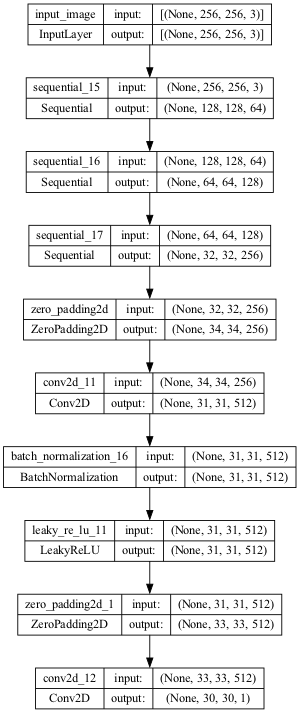

In [12]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [13]:
##discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [14]:
#setting generator and discriminator for monet and photo
generate_monet = Generator()
generate_photo = Generator()
discriminate_monet = Discriminator()
discriminate_photo = Discriminator()

#using adam as optimizer with learning rate 0.0002 and beta of 0.5
adam = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
#setting optimizers
generate_monet_opt = adam
generate_photo_opt = adam
discriminate_monet_opt = adam
discriminate_photo_opt = adam

In [15]:
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(display_list[0] * 0.5 + 0.5)
    ax2.imshow(display_list[1] * 0.5 + 0.5)
    ax1.title.set_text(title[0])
    ax2.title.set_text(title[1])
    plt.show()

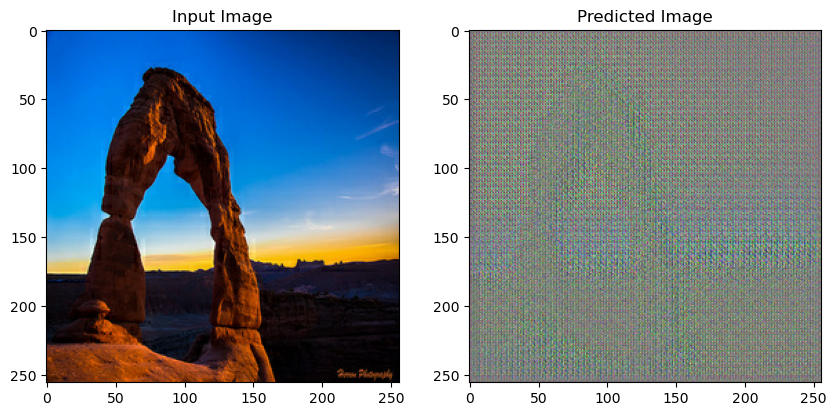

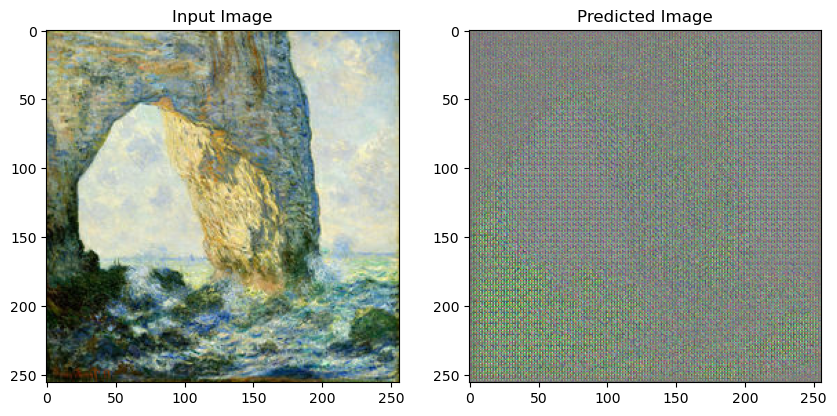

In [16]:
#generate monet from photo
for example_input in photo_dataset.take(1):
    generate_images(generate_monet, example_input)
for example_input in monet_dataset.take(1):
    generate_images(generate_photo, example_input)

In [17]:
#train_step function
@tf.function
def train_step(batch_data):
    real_monet, real_photo = batch_data
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generate_monet(real_photo, training=True)
        fake_photo = generate_photo(real_monet, training=True)
        cycle_photo = generate_photo(fake_monet, training=True)
        cycle_monet = generate_monet(fake_photo, training=True)
        
        same_monet = generate_monet(real_monet, training=True)
        same_photo = generate_photo(real_photo, training=True)
        
        real_monet_discriminate = discriminate_monet(real_monet, training=True)
        fake_monet_discriminate = discriminate_monet(fake_monet, training=True)
        real_photo_discriminate = discriminate_photo(real_photo, training=True)
        fake_photo_discriminate = discriminate_photo(fake_photo, training=True)
        
        loss_generated_monet = generator_loss(fake_monet_discriminate)
        loss_generated_photo = generator_loss(fake_photo_discriminate)
        
        loss_cycled = cycle_loss(real_monet, cycle_monet)
        loss_cycled += cycle_loss(real_photo, cycle_photo)
        total_loss_generated_monet = loss_generated_monet + loss_cycled
        total_loss_generated_monet += identity_loss(real_monet, same_monet)
        total_loss_generated_photo = loss_generated_photo + loss_cycled
        total_loss_generated_photo += identity_loss(real_photo, same_photo)
        
        loss_discriminator_monet = discriminator_loss(real_monet_discriminate, fake_monet_discriminate)
        loss_discriminator_photo = discriminator_loss(real_photo_discriminate, fake_photo_discriminate)
        
    generator_monet_gradients = tape.gradient(total_loss_generated_monet, generate_monet.trainable_variables)
    generator_photo_gradients = tape.gradient(total_loss_generated_photo, generate_photo.trainable_variables)
    
    discriminator_monet_gradients = tape.gradient(loss_discriminator_monet, discriminate_monet.trainable_variables)
    discriminator_photo_gradients = tape.gradient(loss_discriminator_photo, discriminate_photo.trainable_variables)
    
    generate_monet_opt.apply_gradients(
        zip(generator_monet_gradients, generate_monet.trainable_variables)
    )
    generate_photo_opt.apply_gradients(
        zip(generator_photo_gradients, generate_photo.trainable_variables)
    )
    discriminate_monet_opt.apply_gradients(
        zip(discriminator_monet_gradients, discriminate_monet.trainable_variables)
    )
    discriminate_photo_opt.apply_gradients(
        zip(discriminator_photo_gradients, discriminate_photo.trainable_variables)
    )
    return {
        'generator_monet_loss': total_loss_generated_monet,
        'generator_photo_loss': total_loss_generated_photo,
        'discriminator_monet_loss': loss_discriminator_monet,
        'discriminator_photo_loss': loss_discriminator_photo
    }

In [18]:
#https://keras.io/examples/generative/cyclegan/

class CycleGan(keras.Model):
    def __init__(self):
        super().__init__()
        self.generate_monet = generator
        self.generate_photo = generator
        self.discriminate_monet = discriminator
        self.discriminate_photo = discriminator
        lambda_cycle=10.0,
        lambda_identity=0.5
    def compile(self):
        super().compile()
        self.generate_monet_opt = generate_monet_opt,
        self.generate_photo_opt = generate_photo_opt,
        self.discriminate_monet_opt = discriminate_monet_opt,
        self.discriminate_photo_opt = discriminate_photo_opt
    def model_encoder(self, filters, size, apply_batch_norm=True):
        return encoder(filters, size, apply_batch_norm=True)
    def model_decoder(self, filters, size, apply_dropout=True):
        return decoder(filters, size, apply_dropout=True)
    def model_generator(self):
        return generator
    def model_discriminator(self):
        return discriminator
        

SyntaxError: invalid syntax (3156173019.py, line 7)